# **<center>CNS 2022**
## <center> NEST Workshop: Plasticity Tutorial
### <center>16/07/2022
### <center>Melbourne, Australia

Tutor: Jasper Albers [<span>&#9993;</span>](mailto:j.albers@fz-juelich.de)  
Material by: Agnes Korcsak-Gorzo [<span>&#9993;</span>](mailto:a.korcsak-gorzo@fz-juelich.de)
    
This tutorial is based on scripts from the example base of the NEST simulator.

## Introduction

Different plasticity mechanisms on different time-scales:

- short-term plasticity: 10 to 1000 ms
- long-term plasticity: minutes to hours
- homeostatic plasticy (synaptic scaling): days
- structural plasticity: hours to days
- meta-plasticity: minutes to hours,
- intrinsic plasticity: hours to days

In this tutorial, we will simulate plasticity mechanisms that are available in NEST and visualize their effects on the connectivity and activity of some networks.

## Setup

In [1]:
import nest
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Tsodyks short-term plasticity

Based on ` tsodyks_depressing.py` and ` tsodyks_facilitating.py`.

In each of the three following experiments, we simulate two neurons.
The first neuron is driven by DC-input and connected to the second neuron, first with a static synapse, then via a facilitating and lastly via a depressing Tsodyks synapse. In each experiment, we record the membrane potential of the second neuron.

In the second experiment, a small facilitation parameter ``U`` causes a slow saturation of the synaptic efficacy
(Eq. 2.2), enabling a facilitating behavior. This experiment reproduces figure 1B of Tsodyks et al. (1998).

In the third experiment, a large facilitation parameter ``U`` causes a fast saturation of the synaptic efficacy (Eq. 2.2), disabling a facilitating behavior. This experiment reproduces figure 1B of Tsodyks et al. (1998).

The NEST implementation is described in Morrison et al. (2018).

*Tsodyks M, Pawelzik K, Markram H (1998). Neural networks with dynamic synapses. Neural computation. [doi:10.1162/089976698300017502](https:/doi.org/10.1162/089976698300017502)*

*A. Morrison, M. Diesmann, and W. Gerstner.  Phenomenological models of synaptic plasticitybased on spike timing.Biological Cybernetics, 98(6):459–478, 2008. [doi:10.1007/s00422-008-0233-1](https://doi.org/10.1007/s00422-008-0233-1).*

<img src="pics/synapse1.png" alt="sketch" width="400" align="center"/>


In [2]:
# set simulation parameters

resolution = .1             # simulation step size (ms)
sim_time = 1200.            # simulation time
dc_start = 50.              # start time of DC input
dc_stop = 1050.             # stop time of DC input

In [3]:
# set neuron parameters

f = 0.02                    # frequency (kHz)

nrn_params = {
    'tau_m': 40.,           # membrane time constant (ms)
    't_ref': 2.,            # refractory time (ms)
    'tau_syn_ex': 1.5,      # exc. synaptic time constant (ms)
    'tau_syn_in': 1.5,      # inh. synaptic time constant (ms)
    'C_m': 40.,             # membrane capacitance (nF)       
    'V_reset': 0.,          # reset potential of membrane potential (mV)
    'E_L': 0.,              # leak potential (mV)
    'V_m': 0.,              # initial membrane potential (mV)
    'V_th': 15.,            # threshold membrane potential (mV)
    }

In [4]:
# set synapse specifications

syn_spec_fac = {
    'tau_psc': 1.5,         # PSC time constant (ms)
    'tau_rec': 130.,        # recovery time from depression (ms)
    'tau_fac': 530.,        # facilitation time constant (ms)
    'U': .03,               # facilitation parameter, asymptotic value of release probability
    'delay': .1,            # synaptic delay (ms)
    'weight': 1540.,        # PSC weight (pA)
    'u': 0.,                # actual release probability
    'x': 1.                 # amount of resources in the recovered state
    }

syn_spec_dep = {
    'tau_psc': 3.,          # PSC time constant (ms)
    'tau_rec': 800.,        # recovery time from depression (ms)
    'tau_fac': 0.,          # facilitation time constant (ms)
    'U': .5,                # facilitation parameter, asymptotic value of release probability
    'delay': .1,            # synaptic delay (ms)
    'weight': 250.,         # PSC weight (pA)
    'u': 0.,                # actual release probability
    'x': 1.                 # amount of resources in the recovered state
    }

In [5]:
p = nrn_params.copy()

I0 = p['V_th'] * p['C_m'] / p['tau_m'] / (1 - np.exp(-(1 / f - p['t_ref']) / p['tau_m']))

In [6]:
# clear NEST memory

nest.ResetKernel()
nest.resolution = resolution

In [7]:
# create and configure neurons and devices

nrns = nest.Create('iaf_psc_exp', 6, nrn_params)

dc_gen = nest.Create('dc_generator', 3, {'amplitude':I0, 'start':dc_start, 'stop':dc_stop})

vm = nest.Create('voltmeter', 3, {'label': 'voltmeter', 'interval':1.})

In [8]:
# connect neurons and devices

syn_spec_static = {'synapse_model': 'static_synapse', 'weight': 1.}
nest.CopyModel('tsodyks_synapse', 'syn_fac', syn_spec_fac)
nest.CopyModel('tsodyks_synapse', 'syn_dep', syn_spec_dep)

nest.Connect(dc_gen[0], nrns[0])
nest.Connect(vm[0], nrns[1])
nest.Connect(nrns[0], nrns[1], syn_spec=syn_spec_static)

nest.Connect(dc_gen[1], nrns[2])
nest.Connect(vm[1], nrns[3])
nest.Connect(nrns[2], nrns[3], syn_spec='syn_fac')

nest.Connect(dc_gen[2], nrns[4])
nest.Connect(vm[2], nrns[5])
nest.Connect(nrns[4], nrns[5], syn_spec='syn_dep')

In [9]:
# simulate

nest.Simulate(sim_time)

In [10]:
# read out variables

nrn_static_t = vm[0].events['times']
nrn_static_v = vm[0].events['V_m']
nrn_static_senders = vm[0].events['senders']

nrn_fac_t = vm[1].events['times']
nrn_fac_v = vm[1].events['V_m']
nrn_fac_senders = vm[1].events['senders']

nrn_dep_t = vm[2].events['times']
nrn_dep_v = vm[2].events['V_m']
nrn_dep_senders = vm[2].events['senders']

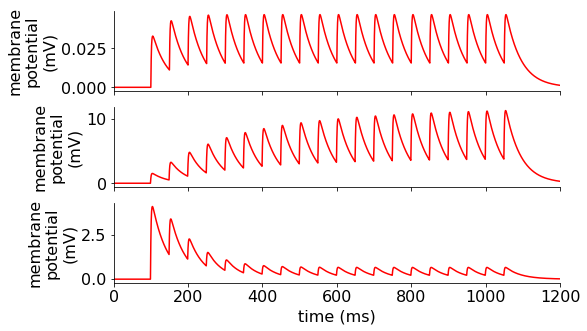

In [11]:
# plot membrane potential time course of facilitating synapses

plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    })

fig, axs = plt.subplots(3, figsize=(8, 5))

axs[0].plot(nrn_static_t, nrn_static_v, c='r')
axs[1].plot(nrn_fac_t, nrn_fac_v, c='r')
axs[2].plot(nrn_dep_t, nrn_dep_v, c='r')

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])

axs[2].set_xlabel('time (ms)')
for ax in axs:
    ax.set_ylabel('membrane\npotential\n(mV)')
    ax.set_xlim(0, sim_time)

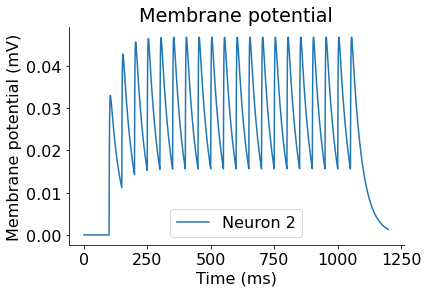

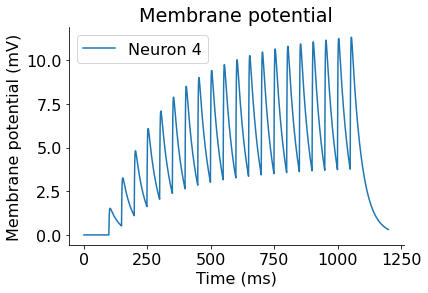

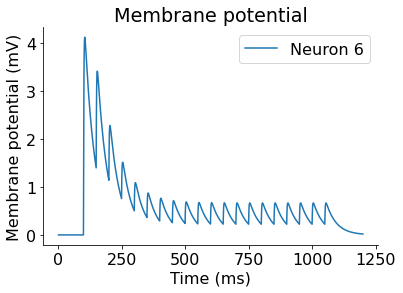

In [12]:
# side remark: you can even more conveniently use the built-in plotting functions of NEST:

import nest.voltage_trace

_ = nest.voltage_trace.from_device(vm[0])
plt.show()

_ = nest.voltage_trace.from_device(vm[1])
plt.show()

_ = nest.voltage_trace.from_device(vm[2])
plt.show()

## Three-factor models

Standard correlation-based rules usually involve two factors, the pre- and post-synaptic spiking, as opposed to three-factor models that involve an additional modulatory signal, e.g., neuromodulation, eligibility traces, voltage.

## Clopath plasticity

Based on `clopath_synapse_small_network.py`.

In this experiment, we simulate a small network of ten excitatory and three
inhibitory ``aeif_psc_delta_clopath`` neurons. The neurons are randomly connected
and driven by 500 Poisson generators. The synapses from the Poisson generators
to the excitatory population and those among the neurons of the network
are plastic Clopath synapses. The rate of the Poisson generators is modulated with
a Gaussian profile whose center shifts randomly each 100 ms between ten
equally spaced positions.
This setup demonstrates that the Clopath synapse is able to establish
bidirectional connections and is adapted from Fig 5 in Clopath et al. (2010).

The NEST implementation is described in Stapmanns et al. (2021).

*Clopath C, Büsing L, Vasilaki E, Gerstner W (2010). Connectivity reflects coding: a model of voltage-based STDP with homeostasis. Nature Neuroscience 13:3, 344--352. [doi:10.1038/nn.2479](https:doi.org/10.1038/nn.2479)*

*J. Stapmanns, J. Hahne, M. Helias, M. Bolten, M. Diesmann, D. Dahmen: Event-Based Update of Synapses in Voltage-Based Learning Rules. Frontiers in Neuroinformatics, 15:609147. [doi: 10.3389/fninf.2021.609147](https://doi.org/10.3389/fninf.2021.609147)*

<img src="pics/stapmanns2021event_fig7a_setup-clopath.png" alt="sketch" width="300" align="center"/>

Fig 7C in Stapmanns et al. (2021)

In [13]:
# set simulation parameters

simulation_time = 1e4
resolution = .1
sim_interval = 100.  # simulate in intervals of 100 ms for shifting the Gaussian

In [14]:
# set neuron parameters

nrn_model = 'aeif_psc_delta_clopath'

nrn_params = {
    # dynamic state variables
    'V_m': -30.6,             # initial membrane potential (mV)
    'w': 0.,                  # spike-adaptation current (pA)
    
    # membrane parameters
    'g_L': 30.,               # leak conductance (nS)
    'tau_u_bar_plus': 7.,     # time constant of the low-pass filtered membrane potential (ms)
    'tau_u_bar_minus': 10.,   # time constant of the low-pass filtered membrane potential (ms)
    'C_m': 281.,              # membrane capacitance (pF)
    
    # spike-adaptation parameters
    'tau_w': 144.,            # adaptation time constant (ms)
    'a': 4.,                  # sub-threshold adaptation (nS)
    'Delta_T': 2.,            # slope factor (mV)
    'V_peak': 20.,            # spike detection threshold (mV)
    'b': .0805,               # spike-triggered adaptation (pA)

     # Clopath rule parameters
    'u_ref_squared': 60.**2,  # reference value for u_bar_bar^2
    'A_LTP': 8e-6,            # amplitude of facilitation (1/mV^2)
    'A_LTD': 14e-6,           # amplitude of depression (1/mV)
    'A_LTD_const': False,     # flag that indicates whether A_LTP should be constant (True) or multiplied
                              # by u_bar^2 / u_ref_squared (False)
    
    # other parameters
    't_clamp': 2.,            # duration of clamping of membrane potential after a spike (ms)
    }

In [15]:
# set network parameters

N_exc = 10   # number exc. neurons
N_inh = 3    # number inh. neurons
N_pg = 500   # number poisson generators

In [16]:
# set connection parameters

w_exc_exc = .25
delay = resolution

In [17]:
# set external input parameters

pg_A = 30.      # amplitude of Gaussian
pg_sigma = 10.  # std deviation of Gaussian

In [18]:
# clear NEST memory

nest.ResetKernel()
nest.resolution = resolution

In [19]:
# create neurons and devices

pop_exc = nest.Create(nrn_model, N_exc, nrn_params)
pop_inh = nest.Create(nrn_model, N_inh, nrn_params)

pg = nest.Create('poisson_generator', N_pg)

# create intermediate parrot neurons since Poisson generators can only be connected
# with static connections
pop_input = nest.Create('parrot_neuron', N_pg)

wr = nest.Create('weight_recorder')

In [20]:
# create connections

syn_spec_static = {'synapse_model': 'static_synapse', 'weight': 1., 'delay': delay}
conn_spec_ata = {'rule': 'all_to_all', 'allow_autapses': False}

nest.CopyModel('clopath_synapse', 'plastic_input_exc', {'Wmax': 3.})
nest.CopyModel('clopath_synapse', 'plastic_exc_exc', {'Wmax': .75, 'weight_recorder': wr})

nest.Connect(pg, pop_input, 'one_to_one', syn_spec_static)

nest.Connect(pop_input, pop_exc, conn_spec_ata,
             {'synapse_model': 'plastic_input_exc',
              'weight': nest.random.uniform(.5, 2.), 'delay': delay})

nest.Connect(pop_input, pop_inh, conn_spec_ata,
             {'synapse_model': 'static_synapse',
              'weight': nest.random.uniform(0., .5), 'delay': delay})

nest.Connect(pop_exc, pop_exc, conn_spec_ata,
             {'synapse_model': 'plastic_exc_exc',
              'weight': w_exc_exc, 'delay': delay})

nest.Connect(pop_exc, pop_inh, {'rule': 'fixed_indegree', 'indegree': 8},
             syn_spec_static)

nest.Connect(pop_inh, pop_exc, {'rule': 'fixed_outdegree', 'outdegree': 6},
             syn_spec_static)

In [21]:
# randomize the initial membrane potential

pop_exc.V_m = nest.random.normal(-60., 25.)
pop_inh.V_m = nest.random.normal(-60., 25.) 

In [22]:
# simulate in intervals

for i in range(int(simulation_time / sim_interval)):
    rates = np.empty(500)  # set rates of poisson generators
    pg_mu = 25 + random.randint(0, 9) * 50  # pg_mu will be randomly chosen out of 25,75,125,...,425,475
    for j in range(500):
        rates[j] = pg_A * np.exp((-1 * (j - pg_mu)**2) / (2 * pg_sigma**2))
        pg[j].rate = rates[j] * 1.75
    nest.Simulate(sim_interval)

In [23]:
# get results for synapse weights of the synapses within the exc. population

# sort weights according to sender and reshape
exc_conns = nest.GetConnections(pop_exc, pop_exc)
idx_array = np.argsort(np.array(exc_conns.source))
targets = np.reshape(np.array(exc_conns.target)[idx_array], (N_exc, N_exc - 1))
weights = np.reshape(np.array(exc_conns.weight)[idx_array], (N_exc, N_exc - 1))

# sort weights according to target
for i, (trgs, ws) in enumerate(zip(targets, weights)):
    idx_array = np.argsort(trgs)
    weights[i] = ws[idx_array]

weight_matrix = np.zeros((N_exc, N_exc))

tu10 = np.triu_indices_from(weight_matrix, 1)
tu9 = np.triu_indices_from(weights)
weight_matrix[tu10[0], tu10[1]] = weights[tu9[0], tu9[1]]

tl10 = np.tril_indices_from(weight_matrix, -1)
tl9 = np.tril_indices_from(weights, -1)
weight_matrix[tl10[0], tl10[1]] = weights[tl9[0], tl9[1]]

# calculate difference between initial and final value
init_w_matrix = (np.ones((N_exc, N_exc)) - np.identity(N_exc)) * w_exc_exc
diff_weight_matrix = weight_matrix - init_w_matrix

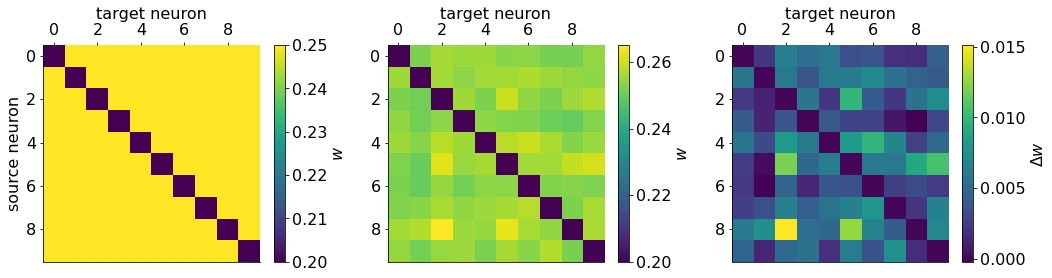

In [24]:
# plot results

plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right' : False,
    'axes.spines.top' : False,
})

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,4))

def plot_weights(ax, weight_matrix, label, ylabel=False, vmin=None):
    cax = ax.imshow(weight_matrix, vmin=vmin)
    cbarB = fig.colorbar(cax, ax=ax)
    cbarB.set_label(label)
    ax.set_xlabel('target neuron')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(0, 10, 2))
    ax.set_yticks(range(0, 10, 2))
    if ylabel:
        _ = ax.set_ylabel('source neuron')

plot_weights(axes[0], init_w_matrix, r'$w$', ylabel=True, vmin=0.2)
plot_weights(axes[1], weight_matrix, r'$w$', vmin=0.2)
plot_weights(axes[2], diff_weight_matrix, r'$\Delta w$')

fig.tight_layout()

## Urbanczik-Senn plasticity

Based on `urbanczik_synapse_example.py`.

The following experiment demonstrates the learning in a compartmental neuron where the
dendritic synapses adapt their weight according to the plasticity rule described in
Urbanczik and Senn (2014). In this simple setup, a spike pattern of 200 poisson
spike trains is repeatedly presented to a neuron that is composed of one
somatic and one dendritic compartment. At the same time, the somatic
conductances are activated to produce a time-varying matching potential.
After the learning, this signal is then reproduced by the membrane
potential of the neuron. This script produces Fig. 1B in Urbanczik and Senn (2014) but uses standard
units instead of the unitless quantities used in the paper.

The NEST implementation is described in Stapmanns et al. (2021).

*R. Urbanczik, W. Senn (2014): Learning by the Dendritic Prediction of Somatic Spiking. Neuron, 81, 521-528. [doi: 10.1016/j.neuron.2013.11.030](https://doi.org/10.1016/j.neuron.2013.11.030)*

*J. Stapmanns, J. Hahne, M. Helias, M. Bolten, M. Diesmann, D. Dahmen: Event-Based Update of Synapses in Voltage-Based Learning Rules. Frontiers in Neuroinformatics, 15:609147. [doi: 10.3389/fninf.2021.609147](https://doi.org/10.3389/fninf.2021.609147)*

<img src="pics/urbanczik2014learning_fig1a_neuron-model.png" alt="sketch" width="300" align="center"/>

Fig 1A in Urbanczik and Senn et al. (2014)

In [25]:
# clear memory of NEST kernel

nest.ResetKernel()

In [26]:
# set neuron parameters

nrn_model = 'pp_cond_exp_mc_urbanczik'

phi_params = {             # parameters of rate function
    'phi_max': .15,        # maximal rate (kHz)
    'rate_slope': .5,      # called 'k' in the paper, shift and rescale
    'beta': 1. / 3.,       # slope
    'theta': -55.,         # spiking threshold (mV), shift
    }

nrn_params = {
    't_ref': 3.,           # refractory period (ms)
    'g_sp': 600.,          # soma-to-dendritic coupling conductance (nS)
    'soma': {
        'V_m': -70.,       # initial membrane potential (mV)
        'C_m': 300.,       # membrane capacitance (pF)
        'E_L': -70.,       # resting potential (mV)
        'g_L': 30.,        # leak conductance (nS)
        'E_ex': 0.,        # exc. reversal potential (mV)
        'E_in': -75.,      # inh. reversal potential (mV)
        'tau_syn_ex': 3.,  # exc. synaptic time constant (ms)
        'tau_syn_in': 3.,  # inh. synaptic time constant (ms)
    },
    'dendritic': {
        'V_m': -70.,       # initial membrane potential (mV)
        'C_m': 300.,       # membrane capacitance (pF)
        'E_L': -70.,       # resting potential (mV)
        'g_L': 30.,        # leak conductance (nS)
        'tau_syn_ex': 3.,  # exc. synaptic time constant (ms)
        'tau_syn_in': 3.,  # inh. synaptic time constant (ms)
    },
}

nrn_params.update(phi_params)

<img src="pics/urbanczik2014learning_fig1b_time-course.png" alt="sketch" width="800" align="center"/>

Fig 1B in Urbanczik and Senn et al. (2014)

In [27]:
# simulation parameters

n_pattern_rep = 100         # number of repetitions of the spike pattern
pattern_duration = 200.     

t_start = 2. * pattern_duration
t_end = n_pattern_rep * pattern_duration + t_start

simulation_time = t_end + 2. * pattern_duration
n_rep_total = int(np.around(simulation_time / pattern_duration))

resolution = .1
nest.resolution = resolution

In [28]:
# set synapse parameters

rt = nest.GetDefaults(nrn_model)['receptor_types']

syn_params = {
    'receptor_type': rt['dendritic_exc'],           # receptor type
    'tau_Delta': 100.,                              # low pass filtering time constant of weight change (ms)
    'eta': .17,                                     # learning rate
    'weight': .3 * nrn_params['dendritic']['C_m'],  # initial weight (pA)
    'Wmax': 4.5 * nrn_params['dendritic']['C_m'],   # maximal (cut-off) weight (pA)
    'delay': resolution,                            # delay (ms)
}

In [29]:
# set somatic input parameters

def calculate_g_ex(amplitude, freq, offset, t_start, t_end):
    '''
    Returns weights for the spike generator that drives the excitatory
    somatic conductance.
    '''
    g_ex = lambda t: np.piecewise(t, [(t >= t_start) & (t < t_end)],
                                  [lambda t: amplitude * np.sin(freq * t) + offset, 0.])
    return g_ex

def calculate_g_in(amplitude, t_start, t_end):
    '''
    Returns weights for the spike generator that drives the inhibitory
    somatic conductance.
    '''
    g_in = lambda t: np.piecewise(t, [(t >= t_start) & (t < t_end)],
                                  [amplitude, 0.])
    return g_in

soma_exc_inp = calculate_g_ex(
    amplitude=.016 * nrn_params['dendritic']['C_m'],
    freq=2. * np.pi*2. / pattern_duration,
    offset=.018 * nrn_params['dendritic']['C_m'],
    t_start=t_start,
    t_end=t_end
)

soma_inh_inp = calculate_g_in(
    amplitude=.06 * nrn_params['dendritic']['C_m'],
    t_start=t_start,
    t_end=t_end
)

In [30]:
# set dendritic input parameters

n_pg = 200    # number of poisson generators
p_rate = 10.  # spike rate of poisson generators (Hz)

In [31]:
# create poisson generators for dendritic input

pgs = nest.Create('poisson_generator', n=n_pg, params={'rate': p_rate})
prrt_nrns_pg = nest.Create('parrot_neuron', n_pg)  # intermediate helper neuron
sr = nest.Create('spike_recorder', n_pg)

In [32]:
# connect poisson generators to spike recorders for dendritic input

nest.Connect(pgs, prrt_nrns_pg, {'rule': 'one_to_one'})
nest.Connect(prrt_nrns_pg, sr, {'rule': 'one_to_one'})

In [33]:
# simulate and retrieve spike pattern

nest.Simulate(pattern_duration)
t_srs = [ssr.get('events', 'times') for ssr in sr]

In [34]:
# wipe the memory again for the main simulation

nest.ResetKernel()
nest.resolution = resolution

In [35]:
# create neurons and devices

nrn = nest.Create(nrn_model, params=nrn_params)
prrt_nrns = nest.Create('parrot_neuron', n_pg)

spike_times_soma_inp = np.arange(resolution, simulation_time, resolution)

sg_soma_exc = nest.Create('spike_generator',
                          params={'spike_times': spike_times_soma_inp,
                                  'spike_weights': soma_exc_inp(spike_times_soma_inp)})

sg_soma_inh = nest.Create('spike_generator',
                          params={'spike_times': spike_times_soma_inp,
                                  'spike_weights': soma_inh_inp(spike_times_soma_inp)})

sg_prox = nest.Create('spike_generator', n=n_pg)


mm = nest.Create('multimeter', params={
    'record_from': nest.GetDefaults(nrn_model)['recordables'],
    'interval': .1})
wr = nest.Create('weight_recorder')
sr_soma = nest.Create('spike_recorder')

In [36]:
# create connections

nest.Connect(sg_prox, prrt_nrns, {'rule': 'one_to_one'})

nest.CopyModel('urbanczik_synapse', 'urbanczik_synapse_wr', {'weight_recorder': wr[0]})
syn_params['synapse_model'] = 'urbanczik_synapse_wr'

nest.Connect(prrt_nrns, nrn, syn_spec=syn_params)

nest.Connect(mm, nrn, syn_spec={'delay': .1})

nest.Connect(sg_soma_exc, nrn,
             syn_spec={'receptor_type': rt['soma_exc'], 'weight': 10. * resolution, 'delay': resolution})

nest.Connect(sg_soma_inh, nrn,
             syn_spec={'receptor_type': rt['soma_inh'], 'weight': 10. * resolution, 'delay': resolution})

nest.Connect(nrn, sr_soma)

In [37]:
# simulate in intervals

for i in np.arange(n_rep_total):
    for (sg, t_sp) in zip(sg_prox, t_srs):  # set spike times of pattern for each spike generator
        nest.SetStatus(sg, {'spike_times': np.array(t_sp) + i * pattern_duration})
        
    nest.Simulate(pattern_duration)

In [38]:
# read out devices

mm_events = mm.events
t = mm_events['times']
U = mm_events['V_m.s']
V_w = mm_events['V_m.p']

g_in = mm_events['g_in.s']
g_ex = mm_events['g_ex.s']
I_ex = mm_events['I_ex.p']
I_in = mm_events['I_in.p']

wr_events = wr.events
senders = wr_events['senders']
targets = wr_events['targets']
weights = wr_events['weights']
times = wr_events['times']

spike_times_soma = sr_soma.get('events', 'times')

In [39]:
# derive some further dynamic variables

def calculate_U_M(g_ex, g_in, E_ex, E_in):
    '''
    Returns the matching potential as a function of the somatic conductances.
    '''
    U_M = (g_ex * E_ex + g_in * E_in) / (g_ex + g_in)
    return U_M


def calculate_V_w_star(V_w, g_sp, g_L, E_L):
    '''
    Returns the dendritic prediction of the somatic membrane potential.
    '''
    V_w_star = (g_L * E_L + g_sp * V_w) / (g_L + g_sp)
    return V_w_star


def calculate_phi(U, phi_max, rate_slope, beta, theta):
    '''
    Returns rate function of the soma.
    '''
    phi = phi_max / (1. + rate_slope * np.exp(beta * (theta - U)))
    return phi


def calculate_h(U, rate_slope, beta, theta):
    '''
    Returns derivative of the log(phi).
    '''
    h = 15. * beta / (1. + np.exp(-beta * (theta - U)) / rate_slope)
    return h

U_M = calculate_U_M(g_ex, g_in, nrn_params['soma']['E_ex'], nrn_params['soma']['E_in'])

V_w_star = calculate_V_w_star(V_w, nrn_params['g_sp'], nrn_params['dendritic']['g_L'],
                              nrn_params['dendritic']['E_L'])

phi_U = calculate_phi(U, **phi_params)
phi_U_M = calculate_phi(U_M, **phi_params)
phi_V_w = calculate_phi(V_w, **phi_params)
phi_V_w_star = calculate_phi(V_w_star, **phi_params)

h_V_w_star = calculate_h(V_w_star, phi_params['rate_slope'], phi_params['beta'],
                         phi_params['theta'])

<ipython-input-39-3ef50724a54f>:7: RuntimeWarning:invalid value encountered in true_divide


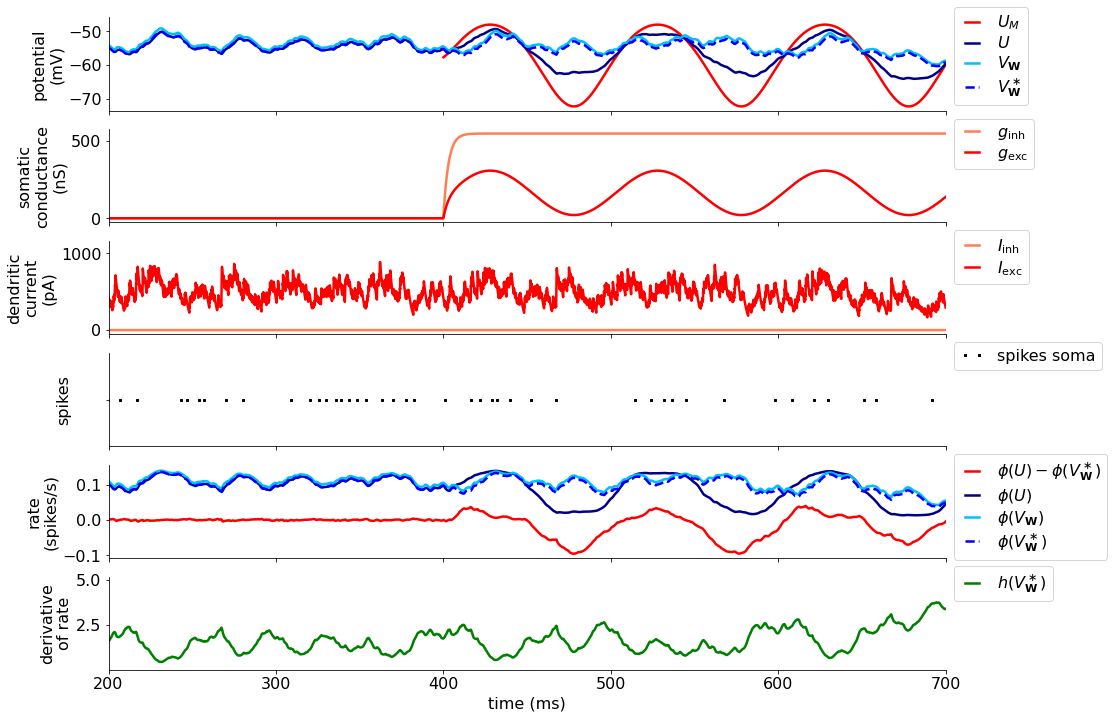

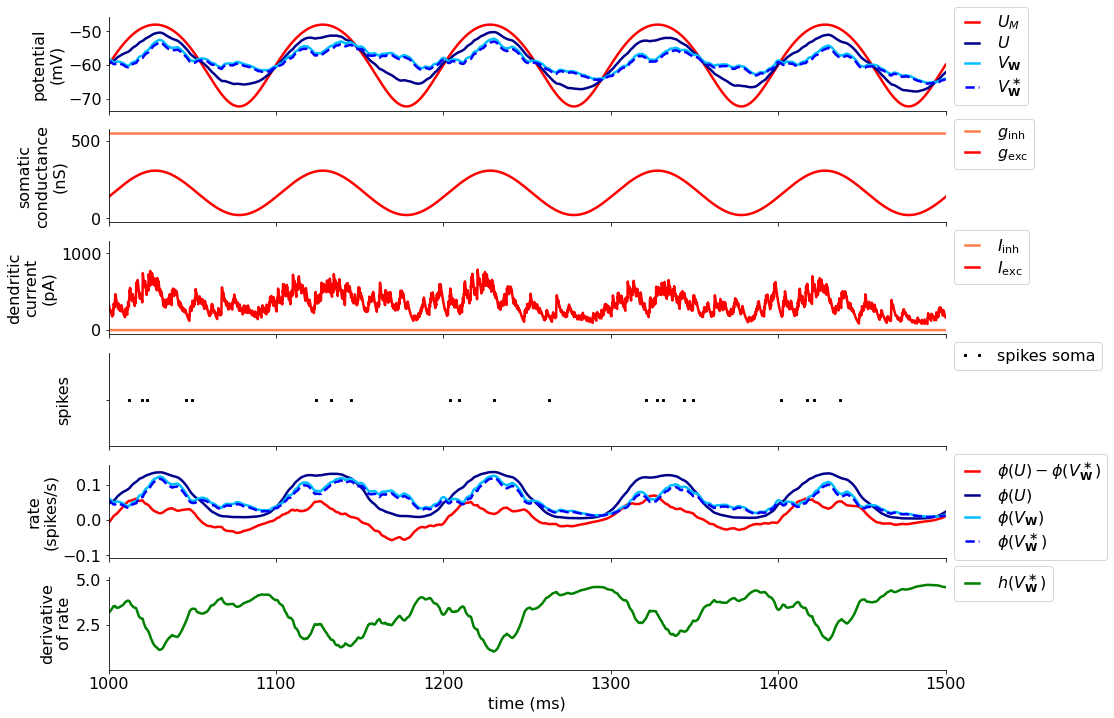

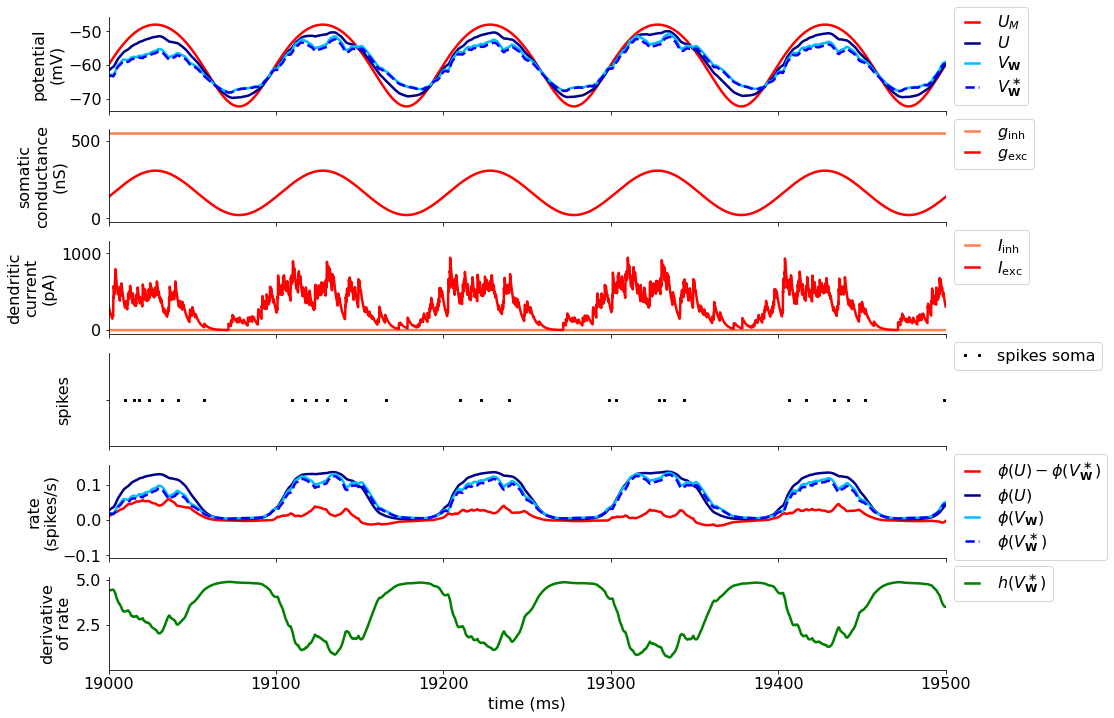

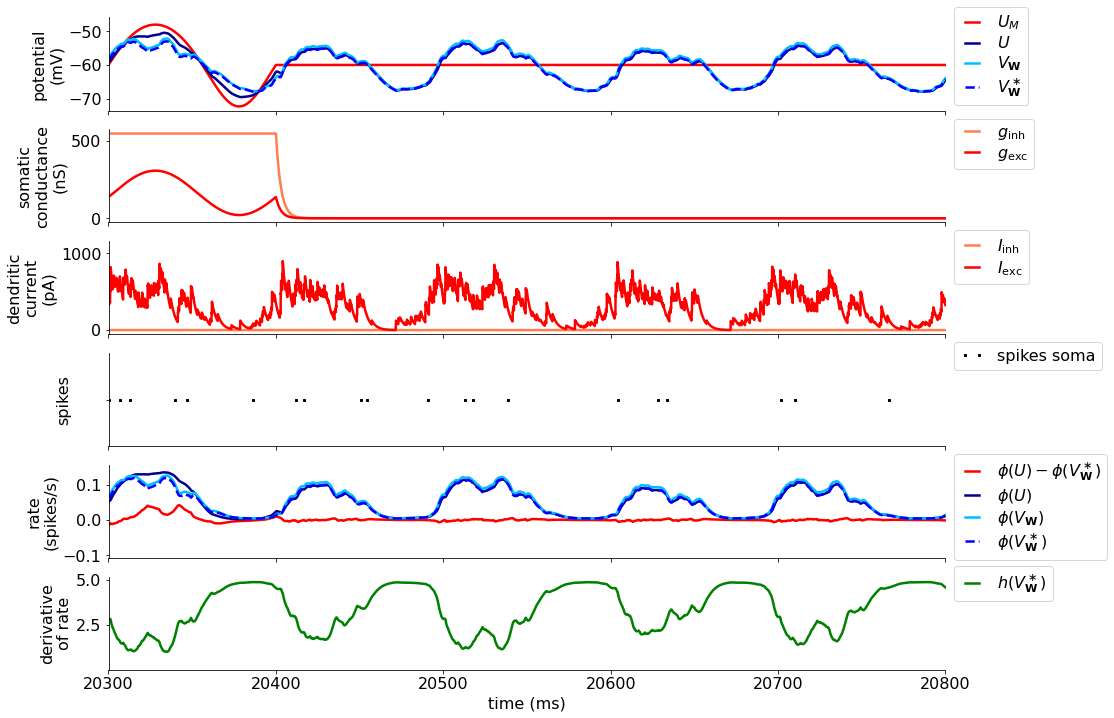

In [42]:
# plot dynamic variables constituting the weight update

plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right' : False,
    'axes.spines.top' : False,
})

legend_params = {
    'ncol': 1,
    'numpoints': 2,
    'labelspacing': .2,
    'columnspacing': .2,
    'loc': 'upper left',
    'bbox_to_anchor': (1., 1.2),
    'handlelength': 1.5,
}
lw = 2.5

idc = np.arange(0, len(t), dtype=int)
t_sub = np.array(t)[idc]

for xlim in ((200, 700), (1000, 1500), (19000, 19500), (20300, 20800)):

    fig, axs = plt.subplots(6, 1, sharex=True, figsize=(15, 12))

    # membrane potentials and matching potential
    axs[0].plot(t_sub, U_M[idc], lw=lw, label=r'$U_M$', color='r', ls='-')
    axs[0].plot(t_sub, U[idc], lw=lw, label=r'$U$', color='darkblue')
    axs[0].plot(t_sub, V_w[idc], lw=lw, label=r'$V_\mathbf{W}$', color='deepskyblue')
    axs[0].plot(t_sub, V_w_star[idc], lw=lw, label=r'$V_\mathbf{W}^\ast$', color='b', ls='--')
    axs[0].set_ylabel('potential\n(mV)')
    axs[0].legend(**legend_params)
    axs[0].set_xlim(xlim)

    # somatic conductances
    axs[1].plot(t_sub, g_in[idc], lw=lw, label=r'$g_\mathrm{inh}$', color='coral')
    axs[1].plot(t_sub, g_ex[idc], lw=lw, label=r'$g_\mathrm{exc}$', color='r')
    axs[1].set_ylabel('somatic\nconductance\n(nS)')
    axs[1].legend(**legend_params)
    axs[1].set_xlim(xlim)

    # dendritic currents
    axs[2].plot(t_sub, I_in[idc], lw=lw, label=r'$I_\mathrm{inh}$', color='coral')
    axs[2].plot(t_sub, I_ex[idc], lw=lw, label=r'$I_\mathrm{exc}$', color='r')
    axs[2].set_ylabel('dendritic\ncurrent\n(pA)')
    axs[2].legend(**legend_params)
    axs[2].set_xlim(xlim)

    # spikes soma
    axs[3].plot(spike_times_soma, np.zeros(len(spike_times_soma)), 's', color='k', markersize=2,
                label='spikes soma')
    axs[3].set_xlim(xlim)
    axs[3].set_ylabel('spikes', labelpad=30)
    axs[3].set_yticks([0.])
    axs[3].set_yticklabels([])
    axs[3].legend(**legend_params)
    
    # rates
    axs[4].plot(t_sub, phi_U[idc] - phi_V_w_star[idc], lw=lw,
                label=r'$\phi(U) - \phi(V_\mathbf{W}^\ast)$', color='r', ls='-')
    axs[4].plot(t_sub, phi_U[idc], lw=lw, label=r'$\phi(U)$', color='darkblue')
    axs[4].plot(t_sub, phi_V_w[idc], lw=lw,
             label=r'$\phi(V_\mathbf{W})$', color='deepskyblue')
    axs[4].plot(t_sub, phi_V_w_star[idc], lw=lw,
             label=r'$\phi(V_\mathbf{W}^\ast)$', color='b', ls='--')
    axs[4].legend(**legend_params)
    axs[4].set_ylabel('rate\n(spikes/s)')
    axs[4].set_xlim(xlim)
    
    # derivative of rate
    axs[5].plot(t_sub, h_V_w_star[idc], lw=lw,
             label=r'$h(V_\mathbf{W}^\ast)$', color='g')
    axs[5].set_xlim(xlim)
    axs[5].legend(**legend_params)
    axs[5].set_ylabel('derivative\nof rate')
    axs[5].set_xlabel('time (ms)')
    
    plt.show()
    print('\n\n')

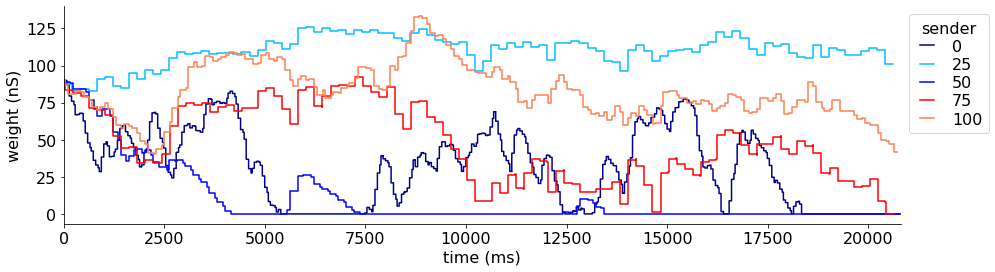

In [44]:
# plot time course of synaptic weights

colors = ['darkblue', 'deepskyblue', 'b', 'r', 'coral']
legend_params = {
    'ncol': 1,
    'numpoints': 2,
    'labelspacing': .2,
    'columnspacing': .2,
    'loc': 'upper left',
    'bbox_to_anchor': (1., 1),
    'handlelength': 1.5,
    'title': 'sender'
}

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
for i, color in zip(np.arange(2, 200, 25), colors):
    index = np.intersect1d(np.where(senders == i), np.where(targets == 1))
    if not len(index) == 0:
        ax.step(times[index], weights[index], label='{}'.format(i - 2), c=color)
ax.set_xlabel('time (ms)')
ax.set_ylabel('weight (nS)')
ax.legend(**legend_params)
ax.set_xlim(0, max(times))
plt.show()

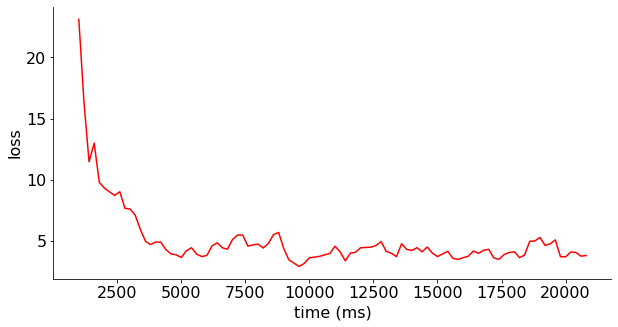

In [45]:
times, loss = [], []
step = int(pattern_duration/resolution)

for pattern_rep_i in range(int(t_start/pattern_duration), int(t_end/pattern_duration)):
    times.append(t_start + (pattern_rep_i + 1)*pattern_duration)
    idc = range(pattern_rep_i*step, (pattern_rep_i + 1) * step)
    loss.append(np.mean((np.array(U)[idc] - np.array(U_M)[idc])**2))

fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(times, loss, c='r')
ax.set_ylabel('loss')
_ = ax.set_xlabel('time (ms)')

## Bored?

- Check out the [official PyNEST tutorials](https://nest-simulator.readthedocs.io/en/latest/tutorials/index.html).
- Have a look at the examples in the [github repo](https://github.com/nest/nest-simulator/tree/v2.20.2) under `pynest/examples` and at the models under `models`.
  - There, you can find more plasticity mechanisms, among others a spike-timing dependent and a structural. plasticity mechanism

## Still bored?
- Start your own project.
- Have a look at the [developer space](http://nest.github.io/nest-simulator/).
- Drink some coffee <span>&#9749;</span>.